# Download Dataset dari Kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mostafaabla/garbage-classification

 99% 236M/239M [00:02<00:00, 81.6MB/s]
100% 239M/239M [00:02<00:00, 95.2MB/s]


In [3]:
import os

In [4]:
!unzip garbage-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classific

#Importing packages

In [5]:
!pip install --upgrade tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
import os

from PIL import Image
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [7]:
# Mendefinisikan jalur dataset
path = '/content/garbage_classification'

#visualisasi data

Jumlah sampel dalam setiap kelas:
{'trash': 697, 'green-glass': 629, 'brown-glass': 607, 'plastic': 865, 'cardboard': 891, 'biological': 985, 'battery': 945, 'white-glass': 775, 'shoes': 1977, 'clothes': 5325, 'metal': 769, 'paper': 1050}


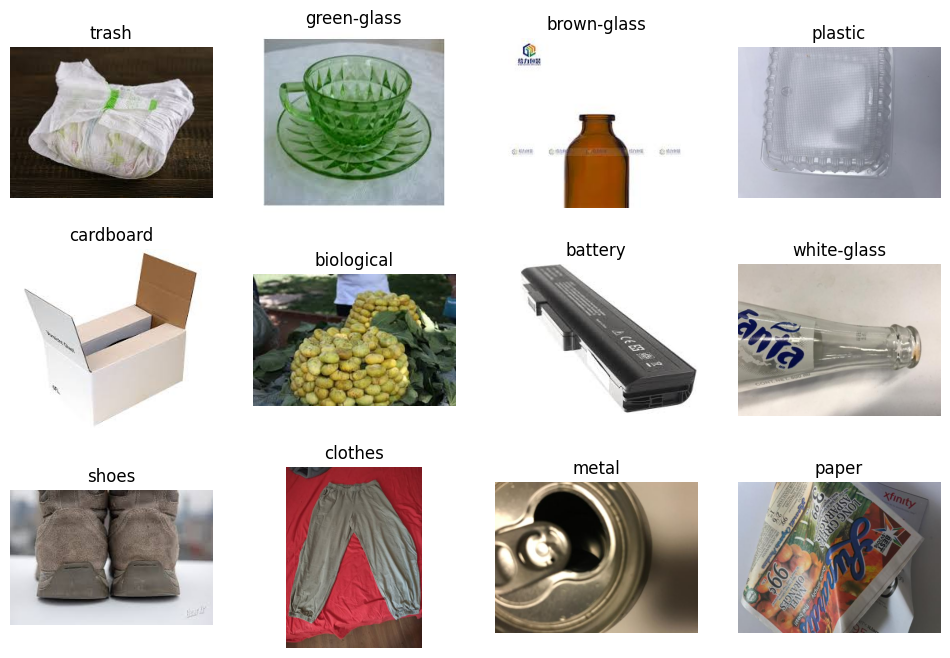

In [8]:
# Melihat jumlah sampel dalam setiap kelas
class_counts = {}
for class_folder in os.listdir('/content/garbage_classification'):
    if os.path.isdir(os.path.join('/content/garbage_classification', class_folder)):
        class_counts[class_folder] = len(os.listdir(os.path.join('/content/garbage_classification', class_folder)))
print("Jumlah sampel dalam setiap kelas:")
print(class_counts)

# Visualisasi sampel gambar
plt.figure(figsize=(12, 8))
class_folders = list(class_counts.keys())
for i, class_folder in enumerate(class_folders):
    image_files = os.listdir(os.path.join('/content/garbage_classification', class_folder))
    sample_image = cv2.imread(os.path.join('/content/garbage_classification', class_folder, image_files[0]))
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 4, i+1)
    plt.imshow(sample_image)
    plt.title(class_folder)
    plt.axis('off')

plt.show()

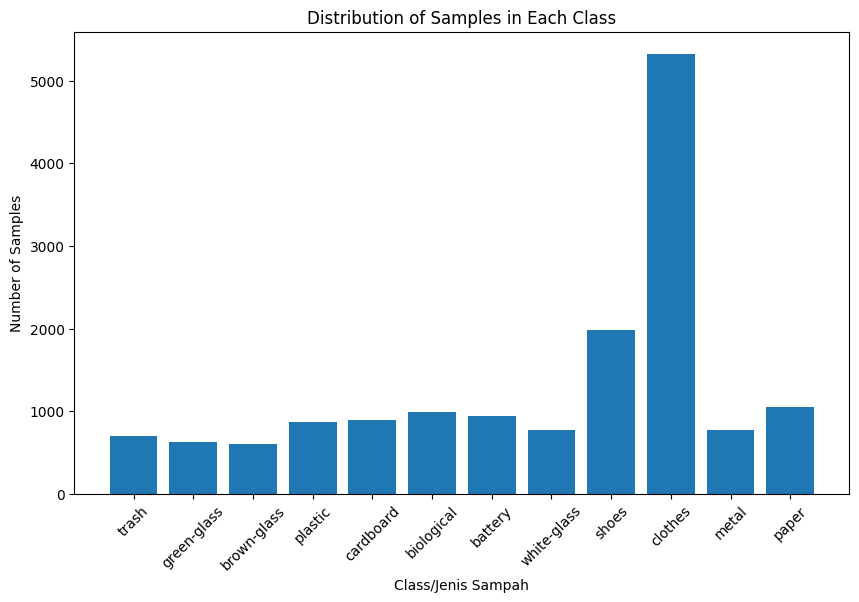

In [9]:
# Menghitung jumlah sampel dalam setiap kelas
class_counts = {}
for class_name in os.listdir('/content/garbage_classification'):
    class_dir = os.path.join('/content/garbage_classification', class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Mengatur plot bar
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class/Jenis Sampah')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Each Class')
plt.xticks(rotation=45)

# Menampilkan plot
plt.show()

In [10]:
folder_names = []
num_images = []

# Loop melalui setiap folder dalam direktori dataset
for folder_name in os.listdir('/content/garbage_classification'):
    folder_path = os.path.join('/content/garbage_classification', folder_name)
    
    # Hanya memeriksa folder (bukan file)
    if os.path.isdir(folder_path):
        image_files = [file for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]
        
        folder_names.append(folder_name)
        num_images.append(len(image_files))

total_images = sum(num_images)
data = {'Folder': folder_names, 'Jumlah Gambar': num_images}
df = pd.DataFrame(data)
total_row = pd.DataFrame({'Folder': ['Total'], 'Jumlah Gambar': [total_images]})
df = pd.concat([df, total_row], ignore_index=True)
df

,Folder,Jumlah Gambar
0,trash,697
1,green-glass,629
2,brown-glass,607
3,plastic,865
4,cardboard,891
5,biological,985
6,battery,945
7,white-glass,775
8,shoes,1977
9,clothes,5325


#Preparing the data

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121


In [25]:
# Mengatur hyperparameter
input_shape = (224, 224, 3)
learning_rate = 0.001
batch_size = 32
num_epochs = 20


In [26]:
# Membuat data generator dengan augmentasi data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [27]:
# Membuat generator data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


#Membangun arsitektur DensNet121

In [28]:
# Menggunakan pre-trained DenseNet121 sebagai base model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Membangun arsitektur model dengan base model DenseNet121
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(12, activation='softmax')
])

# Mengunci bobot pada base model
base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Mengompilasi model
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#Training & Evaluasi Model

In [35]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/20
387/387 [==============================] - 76s 181ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.3478 - val_accuracy: 0.9245
Epoch 2/20
387/387 [==============================] - 68s 176ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.3602 - val_accuracy: 0.9268
Epoch 3/20
387/387 [==============================] - 60s 154ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.3684 - val_accuracy: 0.9281
Epoch 4/20
387/387 [==============================] - 59s 152ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.3549 - val_accuracy: 0.9268
Epoch 5/20
387/387 [==============================] - 69s 177ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.4160 - val_accuracy: 0.9193
Epoch 6/20
387/387 [==============================] - 68s 176ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.3923 - val_accuracy: 0.9258
Epoch 7/20
387/387 [==============================] - 68s 175ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.5634 - val_ac

In [36]:
model.evaluate(validation_generator)

97/97 [==============================] - 16s 164ms/step - loss: 0.4663 - accuracy: 0.9261


[0.4662914574146271, 0.9261290431022644]

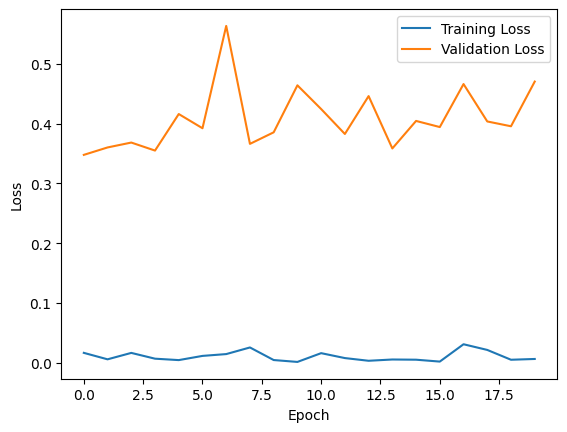

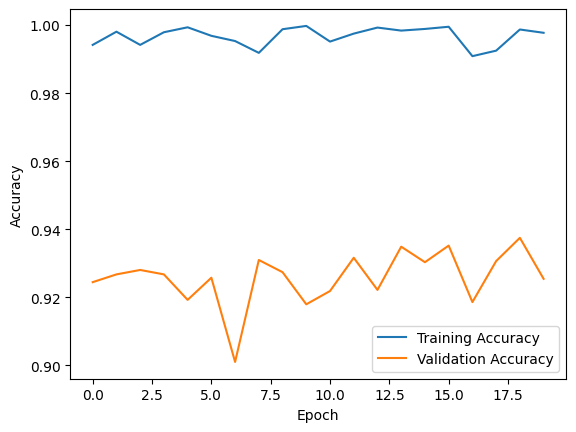

In [48]:
# Membuat plot loss training dan validasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Membuat plot akurasi training dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [49]:
# Menyimpan model
model.save('model_jenis_sampah.h5')

In [66]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
# Memuat model yang telah dilatih
model = keras.models.load_model('model_jenis_sampah.h5')

#Path file gambar yang akan diprediksi
image_path = '/content/test (18).jpg'

# Mengubah gambar menjadi format yang dapat digunakan oleh model
img = image.load_img(image_path, target_size=(224, 224,3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Melakukan prediksi
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Menampilkan hasil prediksi
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']  # Ganti dengan daftar label kelas Anda
predicted_label = class_labels[predicted_class]

print('Prediksi:', predicted_label)
print('Confidence:', confidence)


1/1 [==============================] - 2s 2s/step
Prediksi: trash
Confidence: 1.0


======